# データの確認

## 事前設定

In [1]:
# default packages
import logging
import pathlib
import sys
from datetime import datetime
from typing import Generator, Tuple

In [2]:
# third party
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal
import scipy.stats
import sklearn.preprocessing as skpreprocessing
import sklearn.decomposition as skdecomposition
from IPython.display import display
from mpl_toolkits.mplot3d import axes3d
from scipy import io

In [3]:
# my packages
sys.path.append(str(pathlib.Path("..").resolve()))

In [4]:
import feature
import rank

In [5]:
# autoreload
%load_ext autoreload
%autoreload 2

In [6]:
# logger
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

In [7]:
# settings
DATA_DIR = pathlib.Path("../data")
EXAMPLE_SENSOR = DATA_DIR.joinpath("hs_bearing_1/sensor-20130307T015746Z.mat")
EXAMPLE_TACH = DATA_DIR.joinpath("hs_bearing_1/tach-20130307T015746Z.mat")
SENSOR_FILES = DATA_DIR.glob("hs_bearing_*/sensor-*.mat")

In [8]:
SAMPLING_HZ = 97656
SAMPLING_SEC = 6

## データ読み込み

In [9]:
def load_data(filepath: str) -> pd.DataFrame:
    var = io.loadmat(filepath)
    date_val = datetime.strptime(
        pathlib.Path(filepath).stem.split("-")[-1], "%Y%m%dT%H%M%SZ"
    )

    df = pd.DataFrame(var["v"], columns=["vibration"])
    df["date"] = date_val

    return df

In [10]:
def load_some_files(files: Generator) -> pd.DataFrame:
    df = pd.DataFrame()
    for file in sorted(list(files)):
        logger.info(f"load file: {file}")
        df = pd.concat([df, load_data(file)], ignore_index=True)

    return df

In [11]:
df_org = load_some_files(SENSOR_FILES)

INFO:__main__:load file: ../data/hs_bearing_1/sensor-20130307T015746Z.mat
INFO:__main__:load file: ../data/hs_bearing_1/sensor-20130308T023421Z.mat
INFO:__main__:load file: ../data/hs_bearing_1/sensor-20130309T023343Z.mat
INFO:__main__:load file: ../data/hs_bearing_1/sensor-20130310T030102Z.mat
INFO:__main__:load file: ../data/hs_bearing_1/sensor-20130311T030024Z.mat
INFO:__main__:load file: ../data/hs_bearing_1/sensor-20130312T061710Z.mat
INFO:__main__:load file: ../data/hs_bearing_1/sensor-20130313T063404Z.mat
INFO:__main__:load file: ../data/hs_bearing_1/sensor-20130314T065041Z.mat
INFO:__main__:load file: ../data/hs_bearing_1/sensor-20130315T065003Z.mat
INFO:__main__:load file: ../data/hs_bearing_1/sensor-20130316T065643Z.mat
INFO:__main__:load file: ../data/hs_bearing_2/sensor-20130317T065604Z.mat
INFO:__main__:load file: ../data/hs_bearing_2/sensor-20130317T184756Z.mat
INFO:__main__:load file: ../data/hs_bearing_2/sensor-20130318T184715Z.mat
INFO:__main__:load file: ../data/hs_be

## データ表示

In [12]:
display(df_org.head())

vibration                date
0  -0.414619 2013-03-07 01:57:46
1   0.172490 2013-03-07 01:57:46
2  -0.403777 2013-03-07 01:57:46
3  -0.773542 2013-03-07 01:57:46
4   0.686626 2013-03-07 01:57:46

In [13]:
display(df_org.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29296800 entries, 0 to 29296799
Data columns (total 2 columns):
vibration    float64
date         datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 447.0 MB


None

In [14]:
display(df_org.describe())

vibration
count  2.929680e+07
mean   2.291271e-01
std    2.248586e+00
min   -2.165893e+01
25%   -1.218162e+00
50%    2.281493e-01
75%    1.675297e+00
max    2.296917e+01

In [15]:
def plot_per_day(df: pd.DataFrame) -> None:
    fig = plt.figure()

    for date, data in df.groupby(by=["date"]):
        plt.plot(data["vibration"])

    plt.show()
    plt.close(fig)

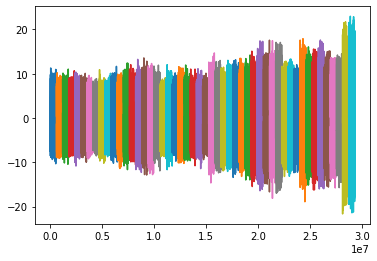

In [16]:
plot_per_day(df_org)

In [17]:
def moving_window_mean(x: np.ndarray, window_size: int, step: int) -> None:
    calc = np.array(
        [
            np.fft.fft(x[idx : idx + window_size])
            for idx in range(0, x.shape[0] - window_size, step)
        ]
    )

    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    X, Y = np.meshgrid(range(calc.shape[1]), range(calc.shape[0]))
    ax.plot_surface(X, Y, calc)

    plt.show()
    plt.clf()

/workspace/python/wind_turbine_high_speed_bearing_prognosis/.venv/lib/python3.7/site-packages/mpl_toolkits/mplot3d/axes3d.py:1760: ComplexWarning: Casting complex values to real discards the imaginary part
  v1[poly_i, :] = ps[i1, :] - ps[i2, :]
/workspace/python/wind_turbine_high_speed_bearing_prognosis/.venv/lib/python3.7/site-packages/mpl_toolkits/mplot3d/axes3d.py:1761: ComplexWarning: Casting complex values to real discards the imaginary part
  v2[poly_i, :] = ps[i2, :] - ps[i3, :]
/workspace/python/wind_turbine_high_speed_bearing_prognosis/.venv/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


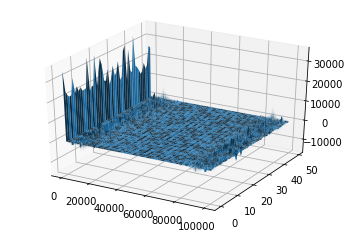

<Figure size 432x288 with 0 Axes>

In [18]:
moving_window_mean(df_org["vibration"].to_numpy(), 100000, SAMPLING_HZ * SAMPLING_SEC)

In [19]:
def pkurtosis(x: np.ndarray, window_size: int, step: int) -> None:
    calc = [
        scipy.signal.spectrogram(
            x[idx : idx + window_size],
            SAMPLING_HZ,
            window=("hann"),
            nperseg=256,
            scaling="spectrum",
        )
        for idx in range(0, x.shape[0] - window_size, step)
    ]
    t = calc[0][1]
    freq = calc[0][0]
    spectrogram = np.array([data for _, _, data in calc])

    # 単一の区間におけるスペクトルを表示
    plt.pcolormesh(t, freq, spectrogram[0, :, :])
    plt.show()
    plt.clf()

    # スペクトル尖度の計算と表示
    kurtosis = scipy.stats.kurtosis(spectrogram, axis=2)
    plt.pcolormesh(freq, range(kurtosis.shape[0]), kurtosis)
    plt.show()
    plt.clf()

    # スペクトル尖度の3D surface表示
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111, projection="3d")
    X, Y = np.meshgrid(freq, range(kurtosis.shape[0]))
    ax.plot_surface(X, Y, kurtosis)
    plt.show()
    plt.clf()

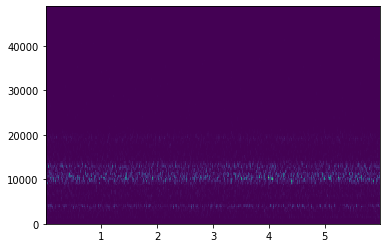

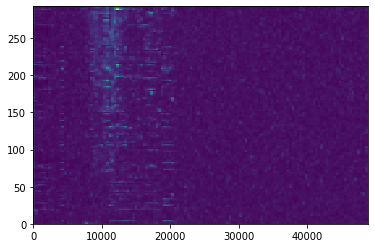

<Figure size 432x288 with 0 Axes>

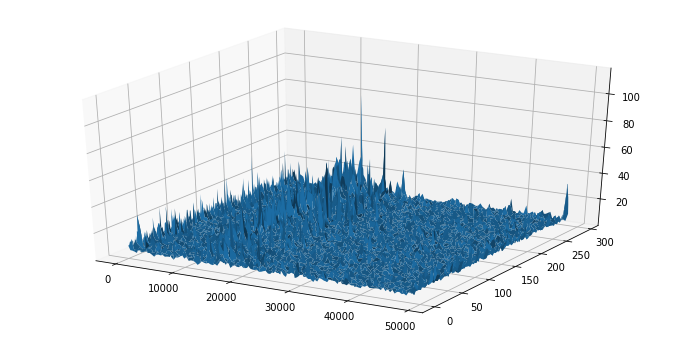

<Figure size 432x288 with 0 Axes>

In [20]:
pkurtosis(
    df_org["vibration"].to_numpy(), SAMPLING_HZ * SAMPLING_SEC, SAMPLING_HZ,
)

In [21]:
def calc_feature(x: np.ndarray) -> None:
    day_sample = SAMPLING_HZ * SAMPLING_SEC
    days = x.shape[0] // day_sample
    df = pd.DataFrame()
    for day in range(days):
        features = feature.calc_all(
            x[day * day_sample : (day + 1) * day_sample], SAMPLING_HZ
        )
        df = df.append({"day": day, **features}, ignore_index=True)
    df = df.set_index(["day"])

    return df

In [22]:
df_feature = calc_feature(df_org["vibration"].to_numpy())

In [23]:
display(df_feature.info())

<class 'pandas.core.frame.DataFrame'>
Float64Index: 50 entries, 0.0 to 49.0
Data columns (total 14 columns):
CrestFactor      50 non-null float64
Energy           50 non-null float64
ImpulseFactor    50 non-null float64
Kurtosis         50 non-null float64
MarginFactor     50 non-null float64
Mean             50 non-null float64
Peak2Peak        50 non-null float64
SKKurtosis       50 non-null float64
SKMean           50 non-null float64
SKSkewness       50 non-null float64
SKStd            50 non-null float64
ShapeFactor      50 non-null float64
Skewness         50 non-null float64
Std              50 non-null float64
dtypes: float64(14)
memory usage: 5.9 KB


None

In [24]:
display(df_feature.describe())

CrestFactor        Energy  ImpulseFactor   Kurtosis  MarginFactor  \
count    50.000000  5.000000e+01      50.000000  50.000000     50.000000   
mean      5.806735  2.993335e+06       7.399682   0.517435      4.197449   
std       0.809181  7.239233e+05       1.143575   0.613507      0.523464   
min       4.693771  1.957502e+06       5.891499  -0.004388      3.362451   
25%       5.216243  2.583731e+06       6.569969   0.084272      3.808673   
50%       5.506683  2.857052e+06       6.990965   0.273951      4.102553   
75%       6.390877  3.220884e+06       8.150835   0.826626      4.439229   
max       7.717529  5.949413e+06      10.284297   2.556594      5.480637   

            Mean  Peak2Peak  SKKurtosis     SKMean  SKSkewness      SKStd  \
count  50.000000  50.000000   50.000000  50.000000   50.000000  50.000000   
mean    0.229127  26.020744   10.199706   6.546610    2.495673   2.824720   
std     0.056807   6.248658   10.364911   0.517026    1.163653   0.970822   
min     0.144064  17.818286   -0.344785   5.770556    0.267848   1.465212   
25%     0.190983  21.596776    4.346206   6.142426    1.734141   1.979009   
50%     0.212420  24.738745    5.907005   6.469961    2.119386   2.622788   
75%     0.259257  30.013149   14.493795   6.974436    3.166506   3.721443   
max     0.358654  44.380840   54.533850   7.897149    6.495807   4.518919   

       ShapeFactor   Skewness        Std  
count    50.000000  50.000000  50.000000  
mean      1.271961  -0.000141   2.233852  
std       0.020594   0.006014   0.253305  
min       1.253517  -0.012744   1.811428  
25%       1.257197  -0.002457   2.075029  
50%       1.264056  -0.000116   2.198488  
75%       1.283753   0.002087   2.334554  
max       1.339602   0.029554   3.175109

In [25]:
display(df_feature.head())

CrestFactor        Energy  ImpulseFactor  Kurtosis  MarginFactor  \
day                                                                     
0.0     4.914735  3.090718e+06       6.160703 -0.004388      3.362451   
1.0     4.912863  2.526572e+06       6.162997  0.019457      3.723132   
2.0     5.214330  2.620761e+06       6.538388  0.022396      3.876629   
3.0     5.286041  2.389443e+06       6.637048  0.041457      4.126636   
4.0     5.005767  2.514967e+06       6.284117  0.044474      3.807824   

         Mean  Peak2Peak  SKKurtosis    SKMean  SKSkewness     SKStd  \
day                                                                    
0.0  0.346052  21.621068    4.838867  5.857048    1.728786  1.742441   
1.0  0.244092  19.309907    4.675419  5.938208    1.805403  1.563850   
2.0  0.218729  21.474075    9.225541  6.118236    2.409214  2.017534   
3.0  0.213717  19.520002   27.136198  6.499296    4.352632  2.988484   
4.0  0.215185  21.216959    2.404748  6.230526    1.041403  1.706924   

     ShapeFactor  Skewness       Std  
day                                   
0.0     1.253517  0.003870  2.270481  
1.0     1.254461  0.003010  2.062146  
2.0     1.253927 -0.001029  2.103553  
3.0     1.255580  0.001477  2.008063  
4.0     1.255376  0.001012  2.060562

In [26]:
def smoothing(df: pd.DataFrame) -> pd.DataFrame:
    span = 5
    x = df.to_numpy()
    x_smooth = np.array(
        [
            np.mean(x[max([0, day - span]) : day + 1, :], axis=0)
            for day in range(len(df))
        ]
    )

    df_smooth = pd.DataFrame(x_smooth, columns=df.columns, index=df.index)

    return df_smooth

In [27]:
df_smooth = smoothing(df_feature)

In [28]:
def show(df1: pd.DataFrame, df2: pd.DataFrame, column_name: str) -> None:
    plt.figure()
    plt.plot(df1[column_name])
    plt.plot(df2[column_name])
    plt.show()
    plt.clf()

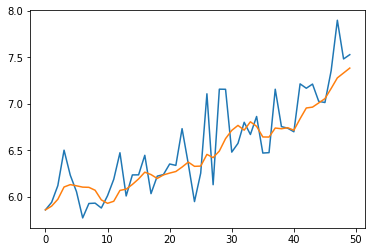

<Figure size 432x288 with 0 Axes>

In [29]:
show(df_feature, df_smooth, "SKMean")

In [30]:
def split_data(
    df: pd.DataFrame, num_of_train: int
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    df_train = df.iloc[:num_of_train, :]
    df_valid = df.iloc[num_of_train:, :]

    return df_train, df_valid

In [31]:
df_train, df_valid = split_data(df_smooth, 20)

In [32]:
def feature_importance(df: pd.DataFrame) -> None:
    scores = {name: rank.monotonicity(df[name].to_numpy()) for name in df.columns}
    df = pd.DataFrame(scores, index=[0])

    return df

In [33]:
df_importance = feature_importance(df_train)

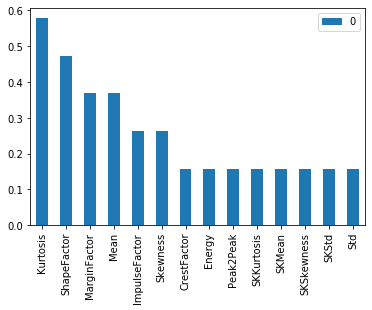

In [34]:
df_importance.T.sort_values(by=[0], ascending=False).plot(kind="bar")
selected_name = df_importance.T[df_importance.T > 0.3].dropna().index

In [35]:
def normalize(
    train: pd.DataFrame, valid: pd.DataFrame
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    ss = skpreprocessing.StandardScaler()
    ss.fit(train)

    train_normalized = ss.transform(train)
    valid_normalized = ss.transform(valid)

    df_nrm_train = pd.DataFrame(
        train_normalized, index=train.index, columns=train.columns
    )
    df_nrm_valid = pd.DataFrame(
        valid_normalized, index=valid.index, columns=valid.columns
    )

    return df_nrm_train, df_nrm_valid

In [36]:
df_normalized_train, df_normalized_valid = normalize(df_train, df_valid)

In [37]:
display(df_normalized_train.describe())

CrestFactor        Energy  ImpulseFactor      Kurtosis  MarginFactor  \
count  2.000000e+01  2.000000e+01   2.000000e+01  2.000000e+01  2.000000e+01   
mean   1.254552e-15 -8.160139e-16  -1.065814e-15 -1.221245e-16 -1.049161e-15   
std    1.025978e+00  1.025978e+00   1.025978e+00  1.025978e+00  1.025978e+00   
min   -1.158688e+00 -1.433757e+00  -1.152820e+00 -1.179846e+00 -2.761941e+00   
25%   -7.622286e-01 -9.903331e-01  -7.681003e-01 -7.287074e-01 -5.904783e-01   
50%   -5.112614e-01  5.007784e-02  -5.074716e-01 -5.335058e-01  4.069917e-01   
75%    9.014309e-01  7.253620e-01   8.975561e-01  6.962328e-01  7.528371e-01   
max    1.973938e+00  2.274486e+00   1.968423e+00  1.833058e+00  1.139510e+00   

               Mean     Peak2Peak    SKKurtosis        SKMean    SKSkewness  \
count  2.000000e+01  2.000000e+01  2.000000e+01  2.000000e+01  2.000000e+01   
mean  -9.603429e-16  4.585221e-15 -4.996004e-16 -9.325873e-15 -1.276756e-16   
std    1.025978e+00  1.025978e+00  1.025978e+00  1.025978e+00  1.025978e+00   
min   -1.019556e+00 -1.086134e+00 -1.530318e+00 -1.935254e+00 -1.786863e+00   
25%   -5.209366e-01 -8.389932e-01 -9.389757e-01 -9.548199e-01 -7.436227e-01   
50%   -4.312950e-01 -4.332885e-01  9.221922e-02  1.890573e-01  5.033476e-02   
75%    2.679790e-01  7.866369e-01  1.053612e+00  5.796762e-01  1.014711e+00   
max    3.454549e+00  1.954123e+00  1.319937e+00  1.600587e+00  1.317282e+00   

              SKStd   ShapeFactor      Skewness           Std  
count  2.000000e+01  2.000000e+01  2.000000e+01  2.000000e+01  
mean  -7.216450e-16 -1.297407e-13  2.775558e-17  5.162537e-15  
std    1.025978e+00  1.025978e+00  1.025978e+00  1.025978e+00  
min   -1.322890e+00 -1.134846e+00 -1.417478e+00 -1.474745e+00  
25%   -8.867573e-01 -7.726011e-01 -9.044974e-01 -9.921459e-01  
50%   -1.899856e-01 -5.479941e-01 -2.307257e-01  6.482583e-02  
75%    9.998025e-01  7.458991e-01  6.717510e-01  7.468951e-01  
max    1.775579e+00  1.789753e+00  2.070803e+00  2.131468e+00

In [38]:
display(df_normalized_valid.describe())

CrestFactor     Energy  ImpulseFactor   Kurtosis  MarginFactor  \
count    30.000000  30.000000      30.000000  30.000000     30.000000   
mean      3.404383   2.234994       3.678521   9.345192      2.389248   
std       2.128425   2.048501       2.336941   7.020086      1.448912   
min       0.053968  -0.677558       0.099423   0.491739     -0.069688   
25%       1.644943   0.214007       1.689909   2.878324      1.540301   
50%       4.046972   2.065192       4.327937   8.810030      2.108393   
75%       5.221104   3.420604       5.748708  14.849670      2.983297   
max       6.403201   7.356193       6.991443  22.688798      5.590886   

            Mean  Peak2Peak  SKKurtosis     SKMean  SKSkewness      SKStd  \
count  30.000000  30.000000   30.000000  30.000000   30.000000  30.000000   
mean   -0.861456   3.819861    1.054200   5.640755    1.520421   3.698908   
std     0.963878   2.672290    1.075518   2.756807    0.708721   1.840276   
min    -2.897642  -0.178980   -0.630867   1.516128    0.167370   1.184690   
25%    -1.254527   1.247294    0.240096   3.348090    0.947423   1.959801   
50%    -0.981283   4.635297    1.114395   5.609169    1.496112   3.414137   
75%    -0.161575   6.106076    1.337003   7.371141    2.045086   4.613177   
max     0.749059   8.526649    3.301547  11.366129    2.919680   7.169769   

       ShapeFactor   Skewness        Std  
count    30.000000  30.000000  30.000000  
mean      8.363605  -0.070943   2.145372  
std       5.984144   0.512209   1.896561  
min       0.625780  -1.230231  -0.694857  
25%       2.763290  -0.415225   0.232884  
50%       8.134041  -0.008653   2.088108  
75%      12.603328   0.289925   3.280258  
max      20.769040   1.083291   6.547455

In [39]:
def show_decomposition(train: pd.DataFrame, valid: pd.DataFrame) -> None:
    pca = skdecomposition.PCA(n_components=2)
    pca.fit(train)

    pca_train = pca.transform(train)
    pca_valid = pca.transform(valid)

    _ = plt.figure()
    plt.plot(
        pca_train[:, 0], pca_train[:, 1], linestyle="None", marker="o", color="blue"
    )
    plt.plot(
        pca_valid[:, 0], pca_valid[:, 1], linestyle="None", marker="o", color="green"
    )
    plt.show()
    plt.clf()

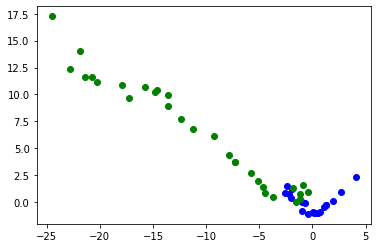

<Figure size 432x288 with 0 Axes>

In [40]:
df_selected_train = df_normalized_train[selected_name]
df_selected_valid = df_normalized_valid[selected_name]
show_decomposition(df_selected_train, df_selected_valid)

In [41]:
def show_health(train: pd.DataFrame, valid: pd.DataFrame) -> None:
    pca = skdecomposition.PCA(n_components=2)
    pca.fit(train)

    pca_train = pca.transform(train)
    pca_valid = pca.transform(valid)

    health_index = 0
    health = np.hstack([pca_train[:, health_index], pca_valid[:, health_index]])

    logger.info(health.shape)

    _ = plt.figure()
    plt.plot(health)
    plt.show()
    plt.clf()

INFO:__main__:(50,)


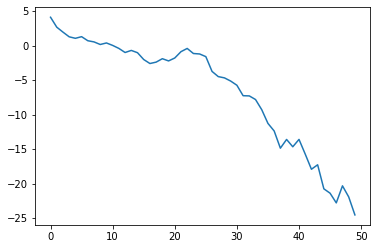

<Figure size 432x288 with 0 Axes>

In [42]:
show_health(df_selected_train, df_selected_valid)